# Covid-19's Impact on Airport Traffic Analysis

## 1. Install Packages & Load the Dataset

In [12]:
# Run the following lines to install needed packages.
# pip install pandas 
# pip install numpy
# pip install matplotlib 
# pip install folium 

In [17]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium

In [18]:
cat = pd.read_csv('archive/covid_impact_on_airport_traffic.csv') # cat == covid_airport_traffic
cat.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


## 2. Preprocessing

In [54]:
# Remove possible columns with na
df = cat.copy(deep=True)
df = cat.dropna()

In [20]:
# Create a sepeate dataframe with AirportName, City and Country
df_geo = df.copy(deep=True)
df_geo = df[['AirportName','Centroid','City','State','Country']]
# Remove repeated rows (Unique values)
df_geo = df_geo.drop_duplicates(subset=["AirportName"], ignore_index=True)
# Adding new columns for longitudes and latitudes as numbers
df_geo['Long'], df_geo['Lat'] = df_geo['Centroid'].str.split(' ').str
df_geo['Long'] = df_geo['Long'].str[6:].astype(float)
df_geo['Lat'] = df_geo['Lat'].str[:-1].astype(float)
df_geo.head()

<ipython-input-20-ae4ab70c5dfe>:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_geo['Long'], df_geo['Lat'] = df_geo['Centroid'].str.split(' ').str


,AirportName,Centroid,City,State,Country,Long,Lat
0,Kingsford Smith,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,Australia,151.180088,-33.945977
1,Santiago International Airport,POINT(-70.7942372739446 -33.3907265266744),Santiago,Santiago Province,Chile,-70.794237,-33.390727
2,Calgary International,POINT(-114.013122872131 51.1184753727795),Calgary,Alberta,Canada,-114.013123,51.118475
3,Edmonton International,POINT(-113.576260685047 53.308783097969),Leduc County,Alberta,Canada,-113.576261,53.308783
4,Vancouver International,POINT(-123.17754124324 49.1935788600694),Richmond,British Columbia,Canada,-123.177541,49.193579


In [61]:
# Sort the data by Date column
df_date = df.copy(deep=True)
df_date = df.sort_values(by=['Date']).reset_index(drop=True)
df_date['Date'] = pd.to_datetime(df_date['Date'], format='%Y-%m-%d')

## 3. Data Analysis and Visualization

3a. Overall Statistics

In [22]:
print("The number of rows of covid_impact_on_airport_traffic dataset is " + str(len(df)) + ".")
airport_names = df['AirportName'].unique()
country_names = df['Country'].unique()
ISO_names = df['ISO_3166_2'].unique()
state_names = df['State'].unique()
city_names = df['City'].unique()
print(airport_names)
print('airport_numbers:' + str(len(airport_names)) + '\n')
print(country_names)
print('country_numbers:' + str(len(country_names)) + '\n')
print(ISO_names)
print('ISO_numbers:' + str(len(ISO_names)) + '\n')
print(state_names)
print('state_numbers:' + str(len(state_names)) + '\n')
print(city_names)
print('city_numbers:' + str(len(city_names)) + '\n')

The number of rows of covid_impact_on_airport_traffic dataset is 7247.
['Kingsford Smith' 'Santiago International Airport'
 'Calgary International' 'Edmonton International'
 'Vancouver International' 'Winnipeg International'
 'Halifax International' 'Toronto Pearson' 'Hamilton International'
 'Montreal Mirabel' 'Montreal Trudeau' 'Los Angeles International'
 'San Francisco International' 'Denver International'
 'Miami International ' 'Hartsfield-Jackson Atlanta International '
 'Daniel K. Inouye International ' 'Chicago OHare International'
 'Boston Logan International ' 'Detroit Metropolitan Wayne County '
 'Charlotte Douglas International' 'Newark Liberty International '
 'McCarran International' 'LaGuardia' 'John F. Kennedy International'
 'Dallas/Fort Worth International ' 'Washington Dulles International '
 'Seattle-Tacoma International ']
airport_numbers:28

['Australia' 'Chile' 'Canada' 'United States of America (the)']
country_numbers:4

['AU' 'CL' 'CA-AB' 'CA-BC' 'CA-MB' 'CA-N

3b. Geographical Map of all airports

In [23]:
airport_map = folium.Map(location=None)

marker = folium.FeatureGroup()
# Previous overall statistics showed that we have 4 countries: Australia, Chile, Canada and the United States of America
# We label airport belonging to different countries with different colors:
# Green: Australia
# Orange: Chile
# Red: Canada
# Blue: the United States of America
for i in range(len(df_geo)):
    country_color = 'blue'
    if df_geo.loc[i, 'Country'] == 'Australia':
        country_color = 'green'
    elif df_geo.loc[i, 'Country'] == 'Chile':
        country_color = 'orange'
    elif df_geo.loc[i, 'Country'] == 'Canada':
        country_color = 'red'
    
    marker.add_child(
        folium.Marker(
            location = [df_geo.loc[i, 'Lat'], df_geo.loc[i, 'Long']],
            popup = '[AirportName]: ' + df_geo.loc[i, 'AirportName'] +
            '. \n [Country]: ' + df_geo.loc[i, 'Country'] +
            '. \n [State]: ' + df_geo.loc[i, 'State'] +
            '. \n [City]: ' + df_geo.loc[i, 'City'] + '.',
            icon = folium.Icon(color=country_color, icon='plane')
        )
    )

airport_map.add_child(marker)
airport_map.add_child(folium.map.LayerControl())
airport_map

3c. Mean bar plots of each country, state, city and airports

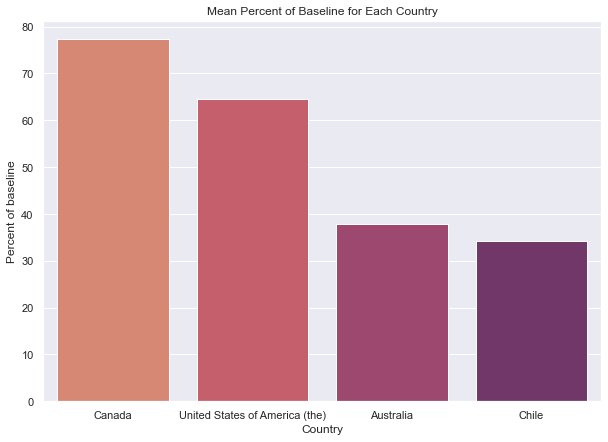

In [35]:
# From PETZERK's work in python file: summary_visualization
# show mean of PercentOfBaseline each country
mean_pob = df.groupby('Country')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='Country', y='PercentOfBaseline', palette='flare')
plt.ylabel('Percent of baseline')
plt.title('Mean Percent of Baseline for Each Country')
plt.show()

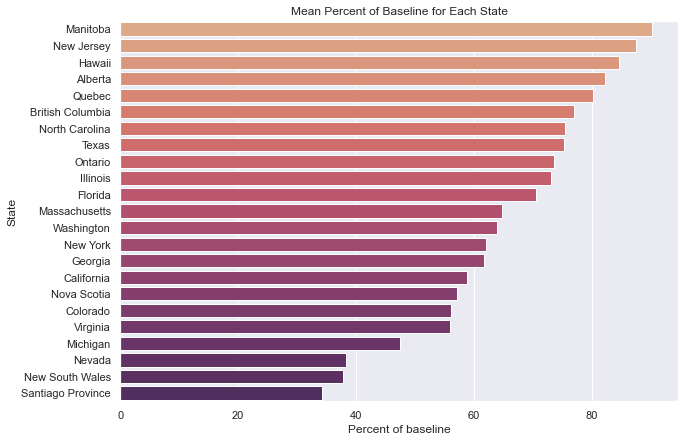

In [39]:
# show mean of PercentOfBaseline each state
mean_pob = df.groupby('State')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='PercentOfBaseline', y='State', palette='flare')
plt.xlabel('Percent of baseline')
plt.title('Mean Percent of Baseline for Each State')
plt.show()

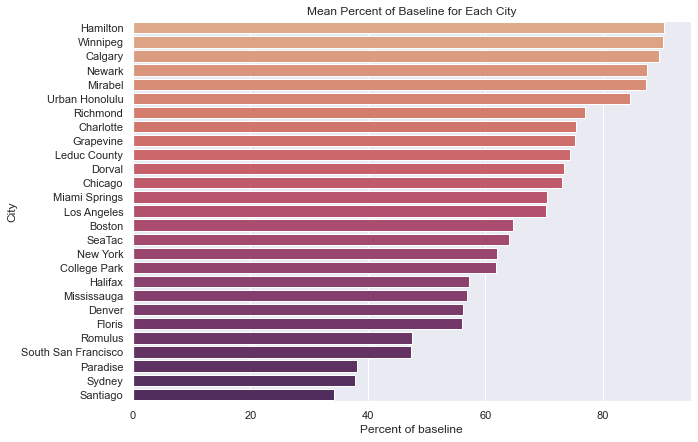

In [40]:
# show mean of PercentOfBaseline each city
mean_pob = df.groupby('City')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='PercentOfBaseline', y='City', palette='flare')
plt.xlabel('Percent of baseline')
plt.title('Mean Percent of Baseline for Each City')
plt.show()

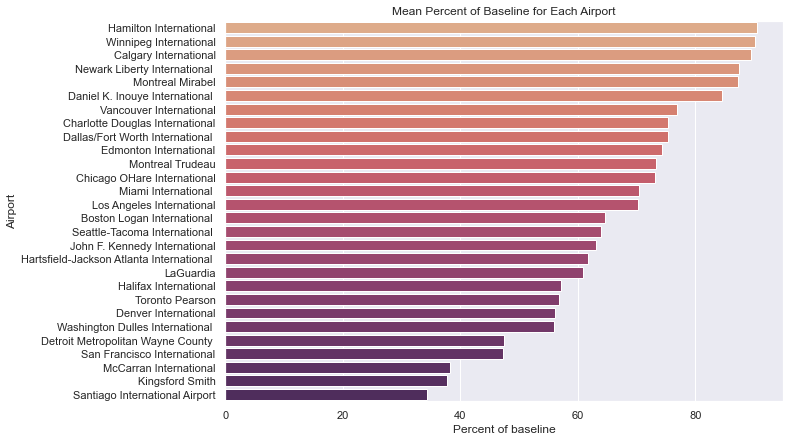

In [42]:
# show mean of PercentOfBaseline each airport
mean_pob = df.groupby('AirportName')['PercentOfBaseline'].mean().sort_values(ascending=False).reset_index()
sns.set(font_scale=1.0)
plt.figure(figsize=[10, 7])
sns.barplot(data=mean_pob, x='PercentOfBaseline', y='AirportName', palette='flare')
plt.xlabel('Percent of baseline')
plt.ylabel('Airport')
plt.title('Mean Percent of Baseline for Each Airport')
plt.show()

3d. Mean activity (PercentOfBaseline) graph by month

In [109]:
# We group all data by month
group_of_month = df_date.groupby(by=df_date['Date'].dt.month)
g = dict(iter(group))
df_month = pd.DataFrame()
df_month['Month'] = df_date['Date'].dt.month.unique()

# Mean Percect Baseline arrays
total_mpct = []
chile_mpct = []
ca_mpct = []
us_mpct = []
au_mpct = []
for i in df_month['Month']:
    total_mpct.append(group_of_month.get_group(i)['PercentOfBaseline'].mean())
    chile_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'Chile']['PercentOfBaseline'].mean())
    ca_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'Canada']['PercentOfBaseline'].mean())
    us_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'United States of America (the)']['PercentOfBaseline'].mean())
    au_mpct.append(group_of_month.get_group(i)[group_of_month.get_group(i)['Country'] == 'Australia']['PercentOfBaseline'].mean())
    
df_month['Total'] = total_mpct
df_month['Chile'] = chile_mpct
df_month['Canada'] = ca_mpct
df_month['United States of America'] = us_mpct
df_month['Australia'] = au_mpct
df_month = df_month.set_index('Month')
df_month.head()

,Total,Chile,Canada,United States of America,Australia
Month,,,,,
3,71.773034,38.400000,77.070423,70.180147,83.125000
4,56.249697,19.571429,63.391473,54.821569,53.241379
5,59.297076,21.444444,71.885185,55.385199,49.129032
6,66.716005,26.846154,80.312030,62.464706,52.517241
7,67.658933,31.107143,78.300725,65.286528,46.258065


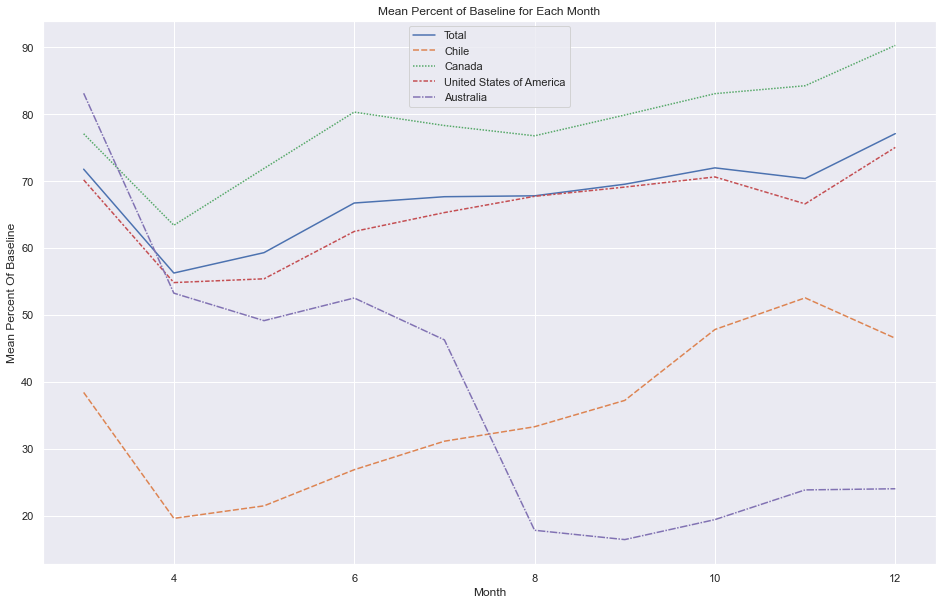

In [116]:
# Plot the graph
sns.set(font_scale=1.0)
plt.figure(figsize=[16, 10])
sns.lineplot(data=df_month)
plt.ylabel('Mean Percent Of Baseline')
plt.title('Mean Percent of Baseline for Each Month')
plt.show()